[View in Colaboratory](https://colab.research.google.com/github/kumarshankar/FADML-Project/blob/master/final_code.ipynb)

In [0]:

import pandas as pd
import matplotlib.pyplot as plt

In [16]:
from google.colab import files
uploaded = files.upload()

Saving regular.txt to regular (2).txt


In [266]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "regular.txt" with length 6506664 bytes


In [0]:
dataset = pd.read_csv('regular.txt', engine='python', sep=',',names =['instructions','cache-references','cache-misses','branches','branch-misses'])

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout,Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
np.random.seed(7)

In [0]:
dataset = dataset.astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [272]:
dataset

array([[0.007904, 0.033317, 0.028722, 0.007906, 0.034996],
       [0.007527, 0.045034, 0.045297, 0.007537, 0.043763],
       [0.007430, 0.026309, 0.032752, 0.007432, 0.029839],
       ...,
       [0.007300, 0.039258, 0.035647, 0.007340, 0.023871],
       [0.008706, 0.029594, 0.010047, 0.008686, 0.020777],
       [0.008471, 0.047963, 0.010955, 0.008491, 0.025786]])

In [273]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

156873 67232


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :])
	return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [276]:
trainX.shape

(156772, 100, 5)

In [277]:
trainY.shape

(156772, 5)

In [278]:
testX.shape

(67131, 100, 5)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[2], trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

In [280]:
trainX.shape

(156772, 5, 100)

In [0]:
model1 = Sequential()
model1.add(LSTM(400, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model1.add(Dropout(0.3))
model1.add(LSTM(400))
model1.add(Dropout(0.3))
model1.add(Dense(5, activation='relu'))
history = model1.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [0]:
history = model1.fit(trainX, trainY,validation_split=0.2, verbose=1,epochs=5)

Train on 125417 samples, validate on 31355 samples
Epoch 1/5


In [282]:
model = Sequential()
model.add(LSTM(5, input_shape=(5, look_back),dropout=0.5,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(5, input_shape=(5, look_back),dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(5,activation="tanh"))
model.add(Dropout(0.5))
model.add(Dense(5,activation="relu"))
#model.add(Activation('relu(x, alpha=0.0, max_value=None)'))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
history = model.fit(trainX, trainY,validation_split=0.33, verbose=1,epochs=3)

Train on 105037 samples, validate on 51735 samples
Epoch 1/3
 42016/105037 [===========>..................] - ETA: 1:17 - loss: 2.9914e-04 - acc: 0.6870

105037/105037 [==============================] - 141s 1ms/step - loss: 2.2238e-04 - acc: 0.7506 - val_loss: 1.0717e-04 - val_acc: 0.8531
Epoch 2/3
  2848/105037 [..............................] - ETA: 1:55 - loss: 1.5666e-04 - acc: 0.8037

105024/105037 [============================>.] - ETA: 0s - loss: 1.4924e-04 - acc: 0.8092

105037/105037 [==============================] - 137s 1ms/step - loss: 1.4923e-04 - acc: 0.8092 - val_loss: 1.0644e-04 - val_acc: 0.8531
Epoch 3/3
 26592/105037 [======>.......................] - ETA: 1:31 - loss: 1.3389e-04 - acc: 0.8109

104992/105037 [============================>.] - ETA: 0s - loss: 1.3811e-04 - acc: 0.8146

105037/105037 [==============================] - 138s 1ms/step - loss: 1.3810e-04 - acc: 0.8146 - val_loss: 1.0651e-04 - val_acc: 0.8531


In [0]:
 # Calculate learning rate decay.
batch_size=200
epochs =5
exp_decay = lambda lr_init, lr_fin, steps: (lr_init/lr_fin)**(1/(steps-1)) - 1
steps = int(trainX.shape[0] / batch_size) * epochs
lr_init, lr_fin = 0.007, 0.0005
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer = optimizers.Adam(lr=lr_init, decay=lr_decay)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

In [212]:
history = model.fit(trainX, trainY,validation_split=0.33, verbose=1,epochs=3)

Train on 105037 samples, validate on 51735 samples
Epoch 1/3
 58880/105037 [===============>..............] - ETA: 32s - loss: 1.2132e-04 - acc: 0.8212

105037/105037 [==============================] - 83s 794us/step - loss: 1.1899e-04 - acc: 0.8236 - val_loss: 1.0839e-04 - val_acc: 0.8531
Epoch 2/3
 19040/105037 [====>.........................] - ETA: 1:00 - loss: 1.1700e-04 - acc: 0.8186

105037/105037 [==============================] - 83s 795us/step - loss: 1.1903e-04 - acc: 0.8236 - val_loss: 1.0991e-04 - val_acc: 0.8531
Epoch 3/3
  4160/105037 [>.............................] - ETA: 1:11 - loss: 1.4191e-04 - acc: 0.8171

100704/105037 [===========================>..] - ETA: 3s - loss: 1.1869e-04 - acc: 0.8243

105037/105037 [==============================] - 84s 795us/step - loss: 1.1902e-04 - acc: 0.8236 - val_loss: 1.0803e-04 - val_acc: 0.8531


In [217]:
print(history.history.values())

dict_values([[0.00010745203745468216, 0.00010712190873754198, 0.0001073014037745628], [0.8529815405477611, 0.8530395283703184, 0.8530781869186899], [0.0002262119770908899, 0.00014184921941162335, 0.00013208704265938516], [0.6711825356784714, 0.7677104258527759, 0.7898264421137126]])


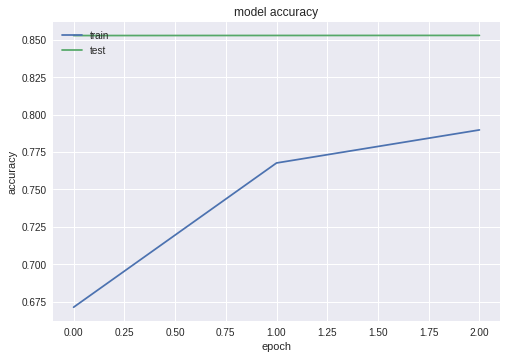

In [218]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

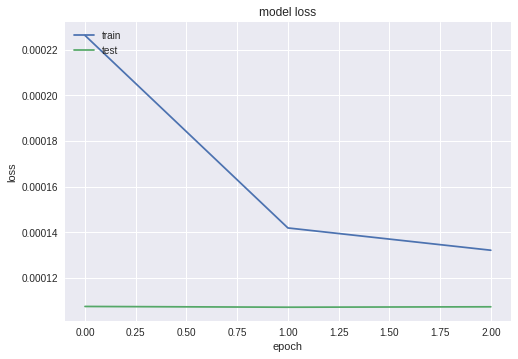

In [219]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 5)                 2120      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 30        
_________________________________________________________________
dropout_11 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 30        
Total params: 2,210
Trainable params: 2,210
Non-trainable params: 0
_________________________________________________________________


In [0]:
# make predictions
trainPredict = model.predict(trainX)

In [0]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

In [222]:
testX.shape

(67131, 100, 5)

In [0]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

In [0]:
testPredict = model.predict(testX)

In [225]:
testPredict.shape

(67131, 5)

In [226]:
trainPredict

array([[0.008284, 0.030149, 0.013654, 0.008875, 0.020522],
       [0.008284, 0.030149, 0.013654, 0.008875, 0.020522],
       [0.008284, 0.030149, 0.013654, 0.008875, 0.020522],
       ...,
       [0.008284, 0.030149, 0.013654, 0.008875, 0.020522],
       [0.008284, 0.030149, 0.013654, 0.008875, 0.020522],
       [0.008284, 0.030149, 0.013654, 0.008875, 0.020522]], dtype=float32)

In [0]:
# invert predictions
trainPredict1 = scaler.inverse_transform(trainPredict)
testPredict1  = scaler.inverse_transform(testPredict)

In [0]:
trainY1 = scaler.inverse_transform(trainY)

In [0]:
testY1 = scaler.inverse_transform(testY)

In [0]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [231]:
np.sqrt(np.mean((trainPredict1 - trainY1)**2,axis=0))

array([4063591.568224, 515.179545, 259.161686, 677192.868352, 129.818554])

In [232]:
np.sqrt(np.mean((testPredict1 - testY1)**2,axis=0))

array([4093157.850371, 542.802527, 303.230366, 685516.646571, 145.402704])

In [0]:
dataset1 = pd.read_csv('regular.txt', engine='python', sep=',',names =['instructions','cache-references','cache-misses','branches','branch-misses'])

In [234]:
dataset1.head()

,instructions,cache-references,cache-misses,branches,branch-misses
0,19074005,1283,506,3179260,484
1,18812335,1711,798,3136494,603
2,18744960,1027,577,3124399,414
3,19307693,1626,291,3218044,551
4,19596547,625,66,3264889,200


In [235]:
from google.colab import files
upload = files.upload()

Saving ransomware.txt to ransomware (3).txt


In [236]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "regular.txt" with length 6506664 bytes


In [0]:
ransom_data = pd.read_csv('ransomware.txt', engine='python', sep=',',names =['instructions','cache-references','cache-misses','branches','branch-misses'])

In [238]:
ransom_data.head()

,instructions,cache-references,cache-misses,branches,branch-misses
0,16979960,1316,448,2907257,525
1,17244181,2325,169,3243123,446
2,19413553,657,36,3223058,329
3,19542654,3541,727,3230837,3043
4,18169995,1402,419,3069996,584


In [0]:
np.random.seed(7)
ransom_data = ransom_data.astype('float32')

In [0]:
scaler1 = MinMaxScaler(feature_range=(0, 1))
ransom_data = scaler1.fit_transform(ransom_data)

In [241]:
ransom_data.shape

(2335, 5)

In [0]:
look_back = 100
X, Y = create_dataset(ransom_data, look_back)

In [243]:
Y.shape

(2234, 5)

In [0]:
dataX = np.reshape(X, (X.shape[0], X.shape[2], X.shape[1]))

In [0]:
ransomPredict = model.predict(dataX)

In [246]:
Y[0]

array([0.013682, 0.000808, 0.000150, 0.011439, 0.000505])

In [247]:
ransomPredict[0]

array([0.008284, 0.030149, 0.013654, 0.008875, 0.020522], dtype=float32)

In [0]:
ransomPredict_unscaled = scaler1.inverse_transform(ransomPredict)

In [249]:
ransomPredict_unscaled[0]

array([15342142.000000, 18606.976562, 4554.663574, 2892123.750000,
       21068.058594], dtype=float32)

In [250]:
Y

array([[0.013682, 0.000808, 0.000150, 0.011439, 0.000505],
       [0.013846, 0.000075, 0.000000, 0.011362, 0.000097],
       [0.013734, 0.011163, 0.002248, 0.011794, 0.004020],
       ...,
       [0.010345, 0.720237, 0.556701, 0.008628, 0.010047],
       [0.013552, 0.001530, 0.000246, 0.011310, 0.000053],
       [0.053099, 0.004492, 0.000018, 0.047008, 0.000315]])

In [0]:
Y1 = scaler1.inverse_transform(Y)

In [252]:
np.sqrt(np.mean((ransomPredict_unscaled - Y1)**2))

11250473.292416302

In [0]:
err_ransom = np.abs(ransomPredict_unscaled - Y1)

In [254]:
err_ransom.shape

(2234, 5)

In [0]:
def club_err(dataset, look_back=50):
	dataX = []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
	return np.array(dataX)

In [0]:
err_win = club_err(err_ransom,50)

In [257]:
err_win.shape

(2183, 50, 5)

In [0]:
f_err = np.mean(err_win,axis=1)

In [0]:
UL = f_err.mean() + 3 * f_err.std()

In [0]:
anomalies = np.where(f_err>=UL)

In [0]:
p_err = np.mean(f_err,axis=1)

In [262]:
anomalies[0].shape

(162,)

In [263]:
np.max(f_err)

24142805.64

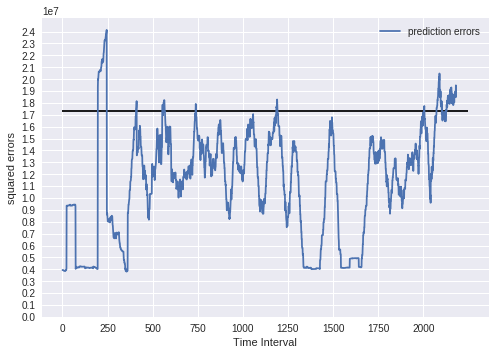

In [264]:
plt.plot(f_err[:,0])
plt.hlines(UL, 0, 2250)
plt.legend(["prediction errors"])
plt.xticks([0,250,500,750,1000,1250,1500,1750,2000])
plt.xlabel("Time Interval")
plt.yticks(range(0,25000000,1000000))
plt.ylabel("squared errors")
plt.show()

In [318]:
anomalies[1].shape

(array([ 196,  197,  198,  199,  200,  201,  202,  203,  204,  205,  206,
         207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
         218,  219,  220,  221,  222,  223,  224,  225,  226,  227,  228,
         229,  230,  231,  232,  233,  234,  235,  236,  237,  238,  239,
         240,  241,  242,  243,  244,  245,  405,  406,  407,  408,  409,
         410,  411,  424,  425,  428,  429,  430,  431,  564,  565, 2067,
        2068, 2069, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
        2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
        2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101,
        2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112,
        2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123,
        2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134,
        2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145,
        2146, 2147, 2148, 2149, 2150, 

In [0]:
UL = ransomPredict_unscaled.mean() + 3 * ransomPredict_unscaled.std()

In [296]:
ransomPredict_unscaled

array([[ 1.4182887e+07,  5.6679600e+03, -3.9681952e+02,  2.6141120e+06,
         3.8692192e+03],
       [ 1.3079339e+07,  9.9848506e+03,  6.1474213e+02,  2.5246278e+06,
         8.2418838e+03],
       [ 1.4915061e+07,  8.1119277e+03, -8.4249371e+02,  2.7364780e+06,
         9.9070352e+03],
       ...,
       [ 1.2808050e+07,  3.6725366e+03,  2.7314737e+02,  2.5491222e+06,
        -2.4019607e+03],
       [ 2.2658522e+07, -1.0856723e+02,  3.1529058e+03,  4.0393172e+06,
         1.6173998e+04],
       [ 1.5596327e+07,  6.7726919e+03, -9.3543340e+03,  1.0616569e+06,
        -3.5977424e+03]], dtype=float32)

In [0]:
ransomPredict_unscaled.mean()

8323.376

In [0]:
Y1

array([[  529.,    67.,   182., ..., 10317.,    59.,   328.]])

In [0]:
anomalies = np.where(Y1>=UL)

In [298]:
anomalies[0].shape

(2003,)

In [0]:
ransomPredict_unscaled.shape

(2284, 1)

In [0]:
Y1.shape

(1, 2284)

In [0]:
df = pd.DataFrame({'observed':np.array(Y1[0,:]),'predicted':np.array(ransomPredict_unscaled[:,0])})

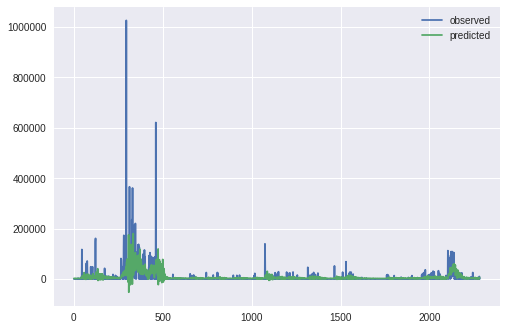

In [0]:
plt.plot(df)
plt.legend(['observed','predicted'])

In [0]:
##### 99  anomalies detected by running on branch-misses